In [1]:
"""
Smart Device Processor Analysis & Recommendation Engine

This Jupyter Notebook serves as the complete data science backend for a
processor recommendation tool. It takes a raw dataset of processor
specifications and produces deployable machine learning models.

Key functions of this notebook include:
- A rule-based recommendation filter to find processors matching specific
  technical requirements (e.g., core count, designer, 5G support).
- A multi-class classification model (RandomForest) to predict a
  processor's primary 'Function' (e.g., SoC, Application Processor)
  based on its architecture.
- A multi-label classification model to infer likely 'Wireless Capabilities'
  (e.g., Wi-Fi 6, 5G) from core specifications alone.

The notebook expects an Excel file named 'Processors.xlsx' and outputs
two trained model pipelines and a label encoder as '.joblib' files,
ready for integration into a web application.
"""

"\nSmart Device Processor Analysis & Recommendation Engine\n\nThis Jupyter Notebook serves as the complete data science backend for a\nprocessor recommendation tool. It takes a raw dataset of processor\nspecifications and produces deployable machine learning models.\n\nKey functions of this notebook include:\n- A rule-based recommendation filter to find processors matching specific\n  technical requirements (e.g., core count, designer, 5G support).\n- A multi-class classification model (RandomForest) to predict a\n  processor's primary 'Function' (e.g., SoC, Application Processor)\n  based on its architecture.\n- A multi-label classification model to infer likely 'Wireless Capabilities'\n  (e.g., Wi-Fi 6, 5G) from core specifications alone.\n\nThe notebook expects an Excel file named 'Processors.xlsx' and outputs\ntwo trained model pipelines and a label encoder as '.joblib' files,\nready for integration into a web application.\n"

In [2]:
# --- SETUP AND DATA LOADING ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re 
import joblib 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Set some display options for better viewing
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Define the path to Excel file
file_path = 'Processors.xlsx' # Assuming the file is in the same directory

try:
    # Load the data from the Excel file into the DataFrame
    df = pd.read_excel(file_path)
    print(f"Successfully loaded '{file_path}'")
    print(f"Dataset Shape: {df.shape}")

except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"The file '{file_path}' was not found.")
    print("Please make sure the Excel file is in the same directory as your Jupyter Notebook.")
    df = pd.DataFrame() # Create an empty dataframe to prevent further errors

Successfully loaded 'Processors.xlsx'
Dataset Shape: (1022, 51)


In [5]:
# --- INITIAL DATA EXPLORATION ---
if not df.empty:
    print("First 5 rows:")
    display(df.head())
    print("\nDataFrame Info:")
    df.info()
    print("\nDescriptive Statistics for Initial Numeric Columns:")
    display(df.describe())
else:
    print("DataFrame is empty. Cannot perform exploration.")

First 5 rows:


,Designer,Serie,Type,Codename,Year Released,Function,Width of Machine Word,Supported Instruction Set(s),Type of processor core(s),Number of processor core(s),Memory Interface(s),Max. Clock Frequency of Memory IF,Data Bus Width,Address Bus Width,Number of data bus channels,Non-volatile Memory Data Bus Width,Non-volatile Memory Interface,DMA Channels,Recommended Minimum Clock Frequency,Recommended Maximum Clock Frequency,Max. Data Rate,L1 Instruction Cache per Core,L0 Instruction Cache per Core,Number of L1 Cache Ways,L1 Data Cache per Core,Number of L2 Cache Ways,Total L2 Cache,Total L3 Cache,Internal Systembus Clock,Pipeline Stages,Instruction Execution Performance,Feature Size,Semiconductor Technology,Number of Transistors Integrated,Pins,Fab,Embedded GPU,Number of GPU cores,GPU Clock,Dedicated Graphics Memory,Supported Cellular Data Links,Supported USB Specification,Bluetooth support,Wireless LAN support,NFC support,Supported Audio/Video Interface,Supported GPS protocol(s),Supported Galileo service(s),Supported GLONASS protocol(s),Supported BeiDou system (BDS),Special Features
0,Qualcomm,Dragonwing,QCS6490 5G,NaN,2023,Multi-core Application Processor with Modem,64 bit,"ARMv8.6-A (A32, A64)",4x Qualcomm Kryo 670 + 4x Qualcomm Kryo 475 Mp...,8,"LPDDR4x SDRAM , LPDDR5 SDRAM",3200 MHz,16 bit,NaN,2 ch,NaN,"UFS 2.2 , UFS 3.1 , UFS 3.1 2-lane",NaN,NaN,2700 MHz max.,25.6 Gbyte/s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6 nm,FinFET,NaN,NaN,TSMC,Qualcomm Adreno 643 GPU,NaN,813 Mhz GPU,NaN,CSD 9.6 kbpsCircuit Switched Data (CSD) is the...,"USB 2.0Released in April 2000, USB 2.0 specifi...",Bluetooth 5.2,"IEEE 802.11aShort range standard, 5 GHz, max. ...",Yes,DisplayPort (Unspecified),Yes,Yes,Yes,B1IBeiDou-2 (COMPASS) B1I signal transmitted b...,"1x Qualcomm Kryo 670 Prime (ARM Cortex-A78, up..."
1,Apple,Bionic,A16 Bionic Lite APL1010 / APL1W10,NaN,2025,Multi-core Application Processor,64 bit,"ARMv8.6-A (A32, A64)",2x Apple Everest + 3x Apple Sawtooth cores,5,"LPDDR4x SDRAM , LPDDR5 SDRAM",3200 MHz,16 bit,NaN,4 ch,NaN,"moviNAND , NAND Flash Interface , SATA , SATA ...",NaN,NaN,3460 MHz max.,51.2 Gbyte/s,192 Kbyte I-Cache,NaN,NaN,128 Kbyte D-Cache,NaN,19456 Kbyte L2,NaN,NaN,NaN,NaN,4 nm,FinFET,NaN,NaN,TSMC,Apple G15P GPU,4-core GPU,1338 MHz GPU,NaN,No,"USB 2.0 , USB 3.0 / USB 3.1 Gen 1 / USB 3.2 Ge...",No,No,NaN,"HDMI (Unspecified) , DisplayPort (Unspecified)...",GPS (NMEA 0183),Yes,Yes,B1I BeiDou receiver,2x high-performance Apple Everest 64-bit ARMv8...
2,Apple,NaN,M3 Lite APL1201 T8122,Ibiza,2025,Multi-core Application Processor,64 bit,"ARMv8.6-A (A32, A64)",4x Apple Everest + 4x Apple Sawtooth cores,8,LPDDR5 SDRAM,3200 MHz,64 bit,32 bit,2 ch,NaN,"eMMC 5.1 , moviNAND , NAND Flash Interface , S...",NaN,NaN,4050 MHz max.,102.4 Gbyte/s,192 Kbyte I-Cache,NaN,NaN,128 Kbyte D-Cache,NaN,20480 Kbyte L2,8192 Kbyte L3,NaN,NaN,NaN,3 nm,FinFET,NaN,NaN,TSMC,Apple G15G GPU,9-core GPU,1338 MHz GPU,NaN,No,"USB 2.0 , USB 3.0 / USB 3.1 Gen 1 / USB 3.2 Ge...",No,"IEEE 802.11a , IEEE 802.11b , IEEE 802.11g , I...",NaN,"HDMI (Unspecified) , DisplayPort (Unspecified)...",GPS (NMEA 0183),Yes,Yes,B1I BeiDou receiver,4x high-performance 64-bit ARMv8-compatible (A...
3,Samsung,Exynos,Exynos 1580 5G S5E8855,NaN,2024,Multi-core Application Processor with Modem,64 bit,ARMv9.2-A,4x ARM Cortex-A720 + 4x ARM Cortex-A520 MPcore,8,LPDDR5 SDRAM,3200 MHz,16 bit,NaN,4 ch,NaN,UFS 3.1,NaN,NaN,2910 MHz max.,51.2 Gbyte/s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4 nm,FinFET,NaN,NaN,Samsung,Samsung Xclipse 540 GPU,NaN,1300 MHz GPU,NaN,"CSD 9.6 kbps , GPRS (Class unspecified) , GPRS...","USB 2.0 , USB 3.0 / USB 3.1 Gen 1 / USB 3.2 Ge...",Bluetooth 5.4,"IEEE 802.11a , IEEE 802.11b , IEEE 802.11g , I...","NFC A , NFC B","DisplayPort (Unspecified) , HDMI 1.4",Yes,"E1 , E5a","L1OF , L2OF","B1I , B2a BeiDou receiver",single ARM Cortex-A720 (up to 2.91 GHz) + trip...
4,Apple,NaN,S10,T8310,2024,System-On-a-Chip,64 bit,"ARMv8.6-A (A32, A64)",2x Apple Sawtooth cores,2,"LPDDR4x SDRAM , LPD


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 51 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Designer                             1022 non-null   object 
 1   Serie                                678 non-null    object 
 2   Type                                 1022 non-null   object 
 3   Codename                             235 non-null    object 
 4   Year Released                        1022 non-null   int64  
 5   Function                             1022 non-null   object 
 6   Width of Machine Word                1022 non-null   object 
 7   Supported Instruction Set(s)         1021 non-null   object 
 8   Type of processor core(s)            1016 non-null   object 
 9   Number of processor core(s)          1022 non-null   int64  
 10  Memory Interface(s)                  1022 non-null   object 
 11  Max. Clock Fr

,Year Released,Number of processor core(s),Number of Transistors Integrated
count,1022.000000,1022.000000,9.100000e+01
mean,2012.702544,4.078278,1.040888e+10
std,7.827822,3.065676,1.971457e+10
min,1979.000000,1.000000,2.900000e+04
25%,2009.000000,1.000000,2.300000e+06
50%,2014.000000,4.000000,3.000000e+09
75%,2018.000000,8.000000,1.510000e+10
max,2025.000000,20.000000,1.140000e+11


In [6]:
# --- DATA CLEANING & PREPROCESSING ---
def clean_numeric_column(series):
    return pd.to_numeric(series.astype(str).str.extract(r'(\d+\.?\d*)', expand=False), errors='coerce')

if not df.empty:
    columns_to_clean = [
        'Max. Clock Frequency of Memory IF', 'Recommended Minimum Clock Frequency', 
        'Recommended Maximum Clock Frequency', 'Max. Data Rate', 'Feature Size',
        'GPU Clock', 'Total L2 Cache', 'Total L3 Cache', 'Number of processor core(s)',
        'Number of Transistors Integrated'
    ]

    for col in columns_to_clean:
        if col in df.columns:
            df[col] = clean_numeric_column(df[col])

    print("Numeric columns cleaned.")

Numeric columns cleaned.


In [7]:
# --- FEATURE ENGINEERING ---
def parse_core_types(core_string):
    if not isinstance(core_string, str):
        return {'num_core_types': 0, 'has_performance_cores': False, 'has_efficiency_cores': False, 'designer_specific_cores': False}
    core_string = core_string.lower()
    core_parts = re.findall(r'(\d+)\s*x\s*([\w\s-]+)', core_string)
    is_designer_specific = any(p in core_string for p in ['kryo', 'everest', 'avalanche', 'tahiti', 'taishan', 'oryon'])
    has_p_cores = bool(re.search(r'cortex-x|cortex-a7|tupai p|tahiti p|everest|avalanche', core_string))
    has_e_cores = bool(re.search(r'cortex-a5|tupai e|tahiti e|sawtooth|blizzard|cortex-a520', core_string))
    return {'num_core_types': len(core_parts), 'has_performance_cores': has_p_cores, 'has_efficiency_cores': has_e_cores, 'designer_specific_cores': is_designer_specific}

def create_connectivity_features(df_in):
    df_out = df_in.copy()
    df_out['has_wifi_6_or_higher'] = df_out['Wireless LAN support'].str.contains('ax|wi-fi 6', case=False, na=False)
    df_out['has_5g'] = df_out['Supported Cellular Data Links'].str.contains('5g', case=False, na=False)
    df_out['has_nfc'] = df_out['NFC support'].str.lower() == 'yes'
    df_out['bluetooth_version'] = clean_numeric_column(df_out['Bluetooth support'])
    df_out['has_usb_3_or_higher'] = df_out['Supported USB Specification'].str.contains('3.', case=False, na=False)
    return df_out

if not df.empty:
    core_features = df['Type of processor core(s)'].apply(parse_core_types)
    df = pd.concat([df, pd.json_normalize(core_features)], axis=1)
    df = create_connectivity_features(df)
    print("Feature engineering complete. New columns added for core architecture and connectivity.")

Feature engineering complete. New columns added for core architecture and connectivity.


In [8]:
# --- CORE RECOMMENDATION ENGINE (FILTERING LOGIC) ---
def recommend_processors(requirements, data):
    if data.empty:
        print("Cannot make recommendations, DataFrame is empty.")
        return pd.DataFrame()
        
    filtered_df = data.copy()
    if 'designer' in requirements and requirements['designer']:
        filtered_df = filtered_df[filtered_df['Designer'].str.lower() == requirements['designer'].lower()]
    if 'year_released' in requirements:
        filtered_df = filtered_df[filtered_df['Year Released'].between(*requirements['year_released'])]
    if 'num_cores' in requirements:
        filtered_df = filtered_df[filtered_df['Number of processor core(s)'].between(*requirements['num_cores'])]
    if 'feature_size_nm' in requirements:
        filtered_df = filtered_df[filtered_df['Feature Size'].between(*requirements['feature_size_nm'])]
    if requirements.get('needs_5g') == True:
        filtered_df = filtered_df[filtered_df['has_5g'] == True]
    if requirements.get('needs_wifi_6') == True:
        filtered_df = filtered_df[filtered_df['has_wifi_6_or_higher'] == True]
    
    display_columns = ['Designer', 'Serie', 'Type', 'Year Released', 'Number of processor core(s)', 'Feature Size', 'Function']
    # Ensure display columns exist before trying to access them
    display_columns = [col for col in display_columns if col in filtered_df.columns]
    
    return filtered_df[display_columns].sort_values(by='Year Released', ascending=False)

if not df.empty:
    print("Recommendation function defined. Testing with an example:")
    requirements_test = {'designer': 'Apple', 'year_released': (2023, 2025), 'num_cores': (8, 99)}
    display(recommend_processors(requirements_test, df))

Recommendation function defined. Testing with an example:


,Designer,Serie,Type,Year Released,Number of processor core(s),Feature Size,Function
2,Apple,NaN,M3 Lite APL1201 T8122,2025,8,3.0,Multi-core Application Processor
7,Apple,NaN,M4 APL1206,2024,10,3.0,Multi-core Application Processor
8,Apple,NaN,M4 Lite APL1206,2024,9,3.0,Multi-core Application Processor
48,Apple,NaN,M2 Pro APL1113 / APL1W13,2023,12,5.0,Multi-core Application Processor
49,Apple,NaN,M3 Pro APL1203,2023,12,3.0,Multi-core Application Processor
50,Apple,NaN,M3 APL1201,2023,8,3.0,Multi-core Application Processor


In [9]:
# --- PREDICTING PROCESSOR FUNCTION ---
if not df.empty:
    print("--- Preparing Data for Function Prediction ---")
    top_functions = df['Function'].value_counts().nlargest(4).index
    df['Function_simplified'] = df['Function'].apply(lambda x: x if x in top_functions else 'Other')
    df_ml = df.dropna(subset=['Function_simplified']).copy()

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df_ml['Function_simplified'])
    print(f"Target classes: {label_encoder.classes_}")

    numeric_features = ['Year Released', 'Number of processor core(s)', 'Feature Size', 'GPU Clock', 'Total L2 Cache', 'Total L3 Cache', 'bluetooth_version']
    categorical_features = ['Designer', 'Semiconductor Technology', 'Fab']
    boolean_features = ['has_wifi_6_or_higher', 'has_5g', 'has_nfc', 'has_performance_cores', 'has_efficiency_cores']
    all_features = numeric_features + categorical_features + boolean_features
    X = df_ml[all_features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
else:
    print("DataFrame is empty. Skipping ML Task 1.")

--- Preparing Data for Function Prediction ---
Target classes: ['Application Processor' 'Application Processor with Modem'
 'Multi-core Application Processor'
 'Multi-core Application Processor with Modem' 'Other']


In [10]:
# Preprocessing, Hyperparameter Tuning, and Training
if not df.empty:
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features), ('bool', 'passthrough', boolean_features)])

    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])
    param_grid = {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [10, 20, None], 'classifier__min_samples_leaf': [1, 2]}

    print("Starting hyperparameter tuning with GridSearchCV...")
    grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters found: {grid_search.best_params_}")
    best_function_model = grid_search.best_estimator_

Starting hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters found: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}



--- Evaluating Best Model for Function Prediction ---
Accuracy: 0.8732

Classification Report:
                                             precision    recall  f1-score   support

                      Application Processor       0.86      0.98      0.91        44
           Application Processor with Modem       0.93      0.82      0.88        17
           Multi-core Application Processor       0.86      0.77      0.81        48
Multi-core Application Processor with Modem       0.87      0.94      0.91        86
                                      Other       1.00      0.40      0.57        10

                                   accuracy                           0.87       205
                                  macro avg       0.90      0.78      0.82       205
                               weighted avg       0.88      0.87      0.87       205



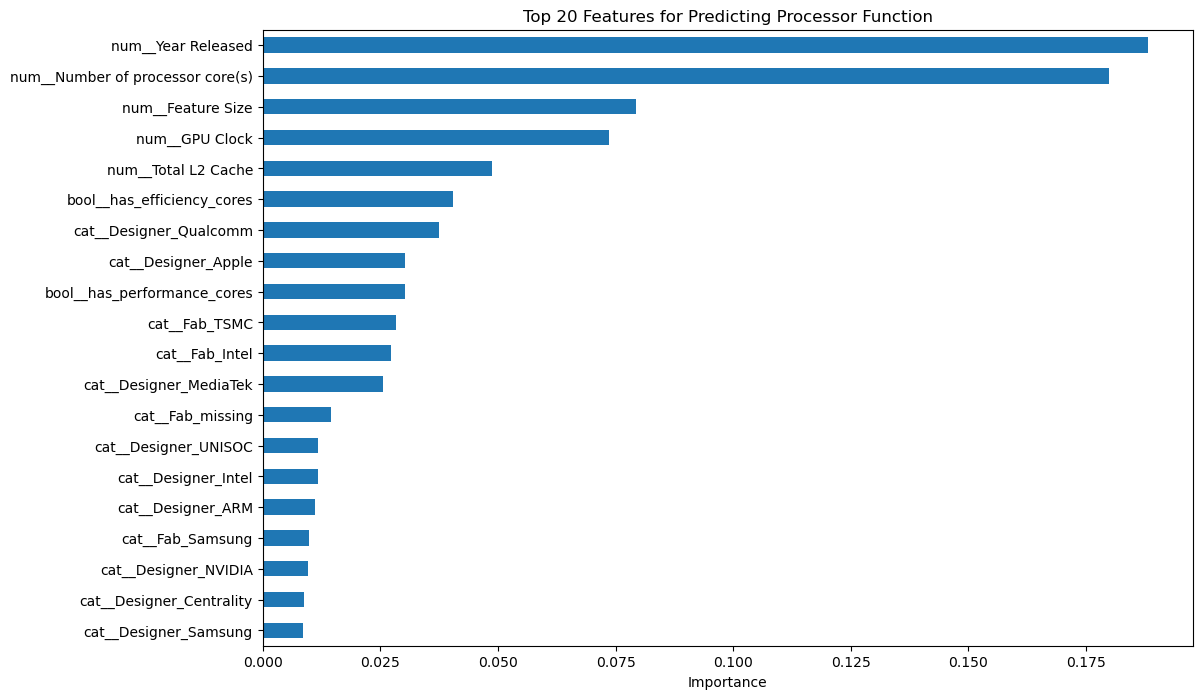

In [11]:
# Evaluation and Feature Importance
if not df.empty:
    print("\n--- Evaluating Best Model for Function Prediction ---")
    y_pred = best_function_model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

    feature_names = best_function_model.named_steps['preprocessor'].get_feature_names_out()
    importances = best_function_model.named_steps['classifier'].feature_importances_
    feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    feat_importances.head(20).plot(kind='barh')
    plt.title('Top 20 Features for Predicting Processor Function')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.show()

In [12]:
# Saving the Model
if not df.empty:
    joblib.dump(best_function_model, 'processor_function_classifier.joblib')
    joblib.dump(label_encoder, 'function_label_encoder.joblib')
    print("Function prediction model and label encoder saved successfully.")

Function prediction model and label encoder saved successfully.


In [13]:
# --- PREDICTING WIRELESS CAPABILITIES ---
if not df.empty:
    print("\n--- Preparing Data for Wireless Capability Prediction ---")
    wireless_targets = ['has_5g', 'has_wifi_6_or_higher', 'has_usb_3_or_higher']
    y_wireless = df_ml[wireless_targets].astype(int)

    X_wireless_features = [
        'Year Released', 'Number of processor core(s)', 'Feature Size', 'GPU Clock',
        'Total L2 Cache', 'Total L3 Cache', 'Designer', 'Semiconductor Technology', 'Fab',
        'has_performance_cores', 'has_efficiency_cores'
    ]
    X_wireless = df_ml[X_wireless_features]

    X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wireless, y_wireless, test_size=0.2, random_state=42)
    print("Data prepared for multi-label classification.")
else:
    print("DataFrame is empty. Skipping ML Task 2.")


--- Preparing Data for Wireless Capability Prediction ---
Data prepared for multi-label classification.


In [14]:
# Training and Evaluating the Wireless Prediction Model
if not df.empty:
    w_numeric_features = X_wireless.select_dtypes(include=np.number).columns.tolist()
    w_categorical_features = X_wireless.select_dtypes(exclude=np.number).columns.tolist()
    w_boolean_features = ['has_performance_cores', 'has_efficiency_cores'] 
    for f in w_boolean_features: 
        w_numeric_features.remove(f) if f in w_numeric_features else None
        w_categorical_features.remove(f) if f in w_categorical_features else None

    preprocessor_wireless = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, w_numeric_features),
            ('cat', categorical_transformer, w_categorical_features),
            ('bool', 'passthrough', w_boolean_features)
        ])

    wireless_model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_wireless),
        ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42)))
    ])

    print("\nTraining the wireless prediction model...")
    wireless_model_pipeline.fit(X_train_w, y_train_w)
    print("Training complete.")

    print("\n--- Evaluating Wireless Prediction Model ---")
    y_pred_w = wireless_model_pipeline.predict(X_test_w)
    y_pred_w_df = pd.DataFrame(y_pred_w, columns=wireless_targets, index=y_test_w.index)

    for feature in wireless_targets:
        print(f"\n--- Classification Report for '{feature}' ---")
        print(classification_report(y_test_w[feature], y_pred_w_df[feature], zero_division=0))


Training the wireless prediction model...
Training complete.

--- Evaluating Wireless Prediction Model ---

--- Classification Report for 'has_5g' ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       205

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205


--- Classification Report for 'has_wifi_6_or_higher' ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       191
           1       0.80      0.86      0.83        14

    accuracy                           0.98       205
   macro avg       0.89      0.92      0.91       205
weighted avg       0.98      0.98      0.98       205


--- Classification Report for 'has_usb_3_or_higher' ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       183
           1       0.86 

In [15]:
# Saving the Model
if not df.empty:
    joblib.dump(wireless_model_pipeline, 'wireless_capabilities_predictor.joblib')
    print("\nWireless capabilities prediction model saved successfully.")


Wireless capabilities prediction model saved successfully.


In [16]:
# --- NOTEBOOK SUMMARY & NEXT STEPS ---
print("""
======================================================================
Jupyter Notebook Phase Complete!
======================================================================

We have successfully completed all data processing and model training.
The following assets have been created and saved to disk:

1. processor_function_classifier.joblib:
   - A trained ML pipeline that takes processor specs and predicts its primary function.
   
2. function_label_encoder.joblib:
   - A utility to convert the numeric output of the function classifier back to human-readable text.

3. wireless_capabilities_predictor.joblib:
   - A trained ML pipeline that predicts a processor's likely connectivity features (5G, Wi-Fi 6, USB 3) based on its core architecture.

The logic from the `recommend_processors` function and these saved model files
are now ready to be integrated into a Flask web application.
""")


Jupyter Notebook Phase Complete!

We have successfully completed all data processing and model training.
The following assets have been created and saved to disk:

1. processor_function_classifier.joblib:
   - A trained ML pipeline that takes processor specs and predicts its primary function.
   
2. function_label_encoder.joblib:
   - A utility to convert the numeric output of the function classifier back to human-readable text.

3. wireless_capabilities_predictor.joblib:
   - A trained ML pipeline that predicts a processor's likely connectivity features (5G, Wi-Fi 6, USB 3) based on its core architecture.

The logic from the `recommend_processors` function and these saved model files
are now ready to be integrated into a Flask web application.

